In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, execute, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# Define the winner and the number of qubits for the database
w='1100'
n=len(w)

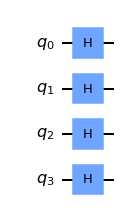

In [4]:
# initialize the database 
qg=QuantumRegister(n,'q')
Grov=QuantumCircuit(qg, name='Grover')
Grov.h(range(n))
Grov.draw()

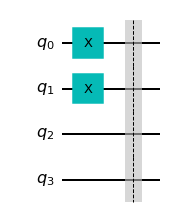

In [5]:
#creation of a SI block circuit 
SIReg=QuantumRegister(n,'q')
SI_Circuit=QuantumCircuit(SIReg, name='SI')
# converting the oracle to the state |1111>
w=w[::-1]
for i in range(n):
    if w[i]=='0':
     SI_Circuit.x(i)
SI_Circuit.barrier()
SI_Circuit.draw()

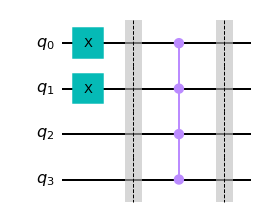

In [5]:
# introduce (-) sign to the state |1111>
from qiskit.circuit.library.standard_gates import ZGate
SI_Circuit.append(ZGate().control(3), SIReg)
SI_Circuit.barrier()
SI_Circuit.draw()

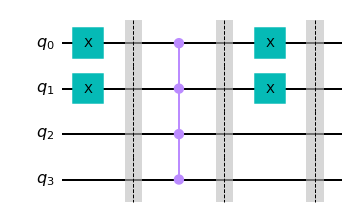

In [6]:
#restitute the value -|0011> of the oracle
for i in range(n):
    if Oracle[i]=='0':
     SI_Circuit.x(i)
SI_Circuit.barrier()
SI_Circuit.draw()

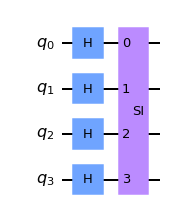

In [7]:
# convert selective inversion to a block gate 
SI = SI_Circuit.to_instruction()
Grov.append(SI, [qg[0], qg[1],qg[2],qg[3]])
Grov.draw()

In [8]:
# creation of the IAA block
IAAReg=QuantumRegister(n,'q')
IAA_Circuit=QuantumCircuit(IAAReg, name='IAA')

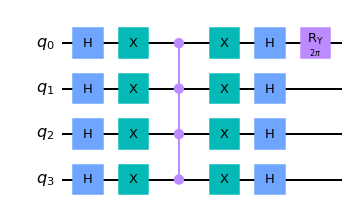

In [9]:
# creation of the IAA circuit
from math import pi
IAA_Circuit.h(range(n))
#converting |0000> to |1111>
IAA_Circuit.x(range(n))
# flipping |1111> to -|1111>
IAA_Circuit.append(ZGate().control(n-1), SIReg)
#restituting -|0000> from -|1111>
IAA_Circuit.x(range(n))
IAA_Circuit.h(range(n))
#introducing (-) to all states
IAA_Circuit.ry(2*pi,0)
IAA_Circuit.draw()

In [10]:
# converting the IAA circuit into instruction (block)
IAA = IAA_Circuit.to_instruction()

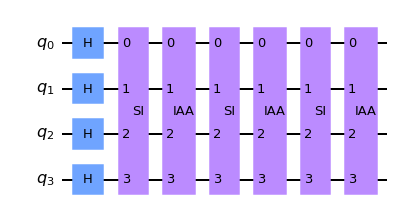

In [11]:
# apply IAA with the SI 
Grov.append(IAA, [qg[0], qg[1],qg[2],qg[3]])
# repeat the the Grover operator (SI+IAA) a second time
Grov.append(SI, [qg[0], qg[1],qg[2],qg[3]])
Grov.append(IAA, [qg[0], qg[1],qg[2],qg[3]])
# repeat the the Grover operator (SI+IAA) a third time
Grov.append(SI, [qg[0], qg[1],qg[2],qg[3]])
Grov.append(IAA, [qg[0], qg[1],qg[2],qg[3]])
Grov.draw()

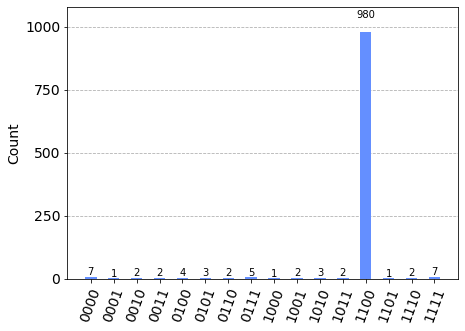

In [12]:
#measure all qubits and plot the results after 1024 shots
Grov.measure_all()
backend = Aer.get_backend('qasm_simulator')
job = execute(Grov, backend, shots=1024)
results = job.result()
Nb = results.get_counts(Grov)
plot_histogram(Nb)